<a href="https://colab.research.google.com/github/SonLee369/Streamlit_python/blob/main/Gemini2.0_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [ ]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [ ]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [ ]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [ ]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [ ]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the strategies of top hedge fund in the world?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the strategies of top hedge fund in the world?'

🤖 Response WITHOUT search tool:


It's tough to give a definitive list of *all* the strategies used by the "top" hedge funds because:

*   **Secrecy:**  Hedge funds often guard their strategies closely to maintain a competitive edge.
*   **Diversification:** Most large hedge funds employ a variety of strategies, not just a single one.
*   **"Top" is Subjective:** Defining "top" can be based on assets under management (AUM), returns, risk-adjusted returns, or other factors. Performance also changes over time.
*   **Evolving Strategies:** Strategies that worked in the past might not work as well in the future due to market changes, increased competition, and regulatory changes.

However, here's a breakdown of common strategies and what's generally known about how sophisticated hedge funds approach them:

**I. Core Investment Strategies:**

*   **Long/Short Equity:**
    *   **Basic Idea:**  Buy stocks expected to increase in value (long positions) and sell stocks expected to decrease in value (short positions).  The goal is to profit from both rising and falling markets, and to reduce overall market exposure (beta).
    *   **Sophisticated Approaches:**
        *   **Factor Investing:**  Using statistical models to identify undervalued or overvalued stocks based on factors like value, growth, momentum, quality, and size. This can involve complex quantitative analysis and data mining.
        *   **Pair Trading:** Identifying pairs of similar companies (e.g., competitors in the same industry) and going long on the relatively undervalued one and short on the relatively overvalued one.  This is often based on statistical arbitrage.
        *   **Sector Specialization:**  Focusing on a particular industry (e.g., technology, healthcare, energy) to develop deep expertise and identify opportunities that generalists might miss.
        *   **Event-Driven Analysis:** Looking for opportunities related to specific corporate events, such as mergers, acquisitions, restructurings, or bankruptcies (see below).
        *   **Quantitative Modeling:** Using complex algorithms to identify patterns and predict stock price movements.

*   **Event-Driven:**
    *   **Basic Idea:**  Capitalizing on opportunities created by corporate events.
    *   **Types:**
        *   **Merger Arbitrage (Risk Arbitrage):** Buying the stock of a company being acquired and shorting the stock of the acquiring company, betting that the deal will close successfully.
        *   **Distressed Investing:**  Investing in the debt or equity of companies in financial distress or bankruptcy, hoping to profit from a turnaround or restructuring.
        *   **Special Situations:** Investing in companies undergoing significant changes, such as spin-offs, recapitalizations, or regulatory changes.
    *   **Sophisticated Approaches:**
        *   **Deep Due Diligence:**  Conducting extensive research and analysis to assess the likelihood of an event occurring and the potential payoff.
        *   **Legal Expertise:**  Understanding the legal and regulatory implications of corporate events.
        *   **Restructuring Expertise:**  Having the skills to analyze and negotiate complex restructurings.
        *   **Hedging:** Employing sophisticated hedging strategies to minimize losses if the event doesn't go as planned.

*   **Fixed Income Arbitrage:**
    *   **Basic Idea:**  Exploiting small price discrepancies between related fixed-income securities.
    *   **Types:**
        *   **Yield Curve Arbitrage:**  Betting on changes in the shape of the yield curve.
        *   **Credit Arbitrage:**  Exploiting differences in credit spreads between different bonds.
        *   **Convertible Arbitrage:**  Buying convertible bonds (bonds that can be converted into stock) and shorting the underlying stock.
        *   **Mortgage-Backed Securities (MBS) Arbitrage:**  Exploiting inefficiencies in the pricing of MBS.
    *   **Sophisticated Approaches:**
        *   **Quantitative Modeling:**  Using sophisticated models to identify mispricings.
        *   **High Leverage:**  Fixed-income arbitrage often involves high leverage to magnify small profits. This also increases risk.
        *   **Sophisticated Hedging:**  Employing complex hedging strategies to protect against interest rate risk and credit risk.

*   **Global Macro:**
    *   **Basic Idea:**  Making investment decisions based on macroeconomic trends and events, such as interest rate changes, currency fluctuations, and political developments.
    *   **Sophisticated Approaches:**
        *   **In-depth Economic Analysis:**  Conducting rigorous economic research and analysis to identify investment opportunities.
        *   **Political Risk Assessment:**  Evaluating the potential impact of political events on financial markets.
        *   **Global Perspective:**  Having a deep understanding of global economic and political trends.
        *   **Use of Derivatives:**  Employing derivatives (e.g., futures, options, swaps) to implement investment strategies.
        *   **Dynamic Asset Allocation:**  Actively adjusting asset allocation based on changing market conditions.

**II. Key Characteristics of Top Hedge Fund Strategies:**

*   **Alpha Generation:** The primary goal is to generate *alpha*, which is investment returns above and beyond what would be expected from a passive investment in the market (beta).  This requires skill, insight, and a competitive edge.
*   **Risk Management:**  Hedge funds place a strong emphasis on risk management.  This includes:
    *   **Diversification:**  Spreading investments across different asset classes, sectors, and geographies.
    *   **Hedging:**  Using derivatives to reduce exposure to specific risks.
    *   **Position Sizing:**  Carefully managing the size of each investment to limit potential losses.
    *   **Stop-Loss Orders:**  Using stop-loss orders to automatically sell positions if they fall below a certain price.
    *   **Stress Testing:**  Simulating the impact of various adverse events on the portfolio.
*   **Sophisticated Technology and Data Analysis:**  Top hedge funds invest heavily in technology and data analysis to gain a competitive edge.  This includes:
    *   **Algorithmic Trading:**  Using computer programs to automatically execute trades based on pre-defined rules.
    *   **Machine Learning:**  Using machine learning algorithms to identify patterns and predict market movements.
    *   **Alternative Data:**  Using non-traditional data sources (e.g., satellite imagery, social media data, credit card transactions) to gain insights into companies and markets.
*   **Talent Acquisition and Retention:**  Hedge funds rely on highly skilled and experienced investment professionals.  They often pay high salaries and bonuses to attract and retain top talent.
*   **Operational Efficiency:**  Hedge funds need to be operationally efficient to manage their complex portfolios and meet the demands of their investors.  This includes:
    *   **Robust Risk Management Systems:**  Having robust systems in place to monitor and manage risk.
    *   **Efficient Trading Operations:**  Having efficient trading operations to execute trades quickly and cost-effectively.
    *   **Strong Investor Relations:**  Maintaining strong relationships with investors.
*   **Adaptability:**  The financial markets are constantly evolving, so hedge funds need to be able to adapt their strategies and processes to remain competitive.
*   **Information Edge:**  Actively seeking and obtaining information that is not widely available to the public. This might involve industry contacts, expert networks, and proprietary research.

**III. Important Considerations:**

*   **Leverage:** Many hedge fund strategies employ leverage (borrowing money to amplify returns). While this can increase profits, it also significantly increases risk.
*   **Liquidity:** Some hedge fund strategies invest in illiquid assets (e.g., private equity, real estate), which can be difficult to sell quickly if needed.
*   **Fees:** Hedge funds typically charge high fees, including a management fee (a percentage of assets under management) and a performance fee (a percentage of profits).  These fees can significantly impact investor returns.
*   **Transparency:**  Hedge funds are often less transparent than other types of investment vehicles, such as mutual funds.  This can make it difficult for investors to assess the risks and potential rewards of investing in a hedge fund.
*   **Regulatory Scrutiny:** Hedge funds are subject to increasing regulatory scrutiny, which can impact their ability to operate.

**In summary, top hedge funds succeed by combining deep expertise in specific areas with sophisticated risk management, advanced technology, and a relentless pursuit of information and alpha. They are constantly evolving to adapt to changing market conditions.**  However, even the best hedge funds can experience periods of underperformance, and there is no guarantee of success.



📝 Same query WITH search: 'What are the strategies of top hedge fund in the world?'

🤖 Response WITH search tool:


Top hedge funds employ a variety of strategies, often combining multiple approaches to maximize returns while managing risk. Here's an overview of some common strategies:

**1. Equity Strategies:**

*   **Long/Short Equity:** Simultaneously holding long positions in stocks expected to increase in value and short positions in stocks expected to decrease. This aims to profit from both rising and falling markets.
*   **Market Neutral:** Aims to eliminate market risk by taking offsetting long and short positions.
*   **Long-Only Equity:** Similar to traditional mutual funds, this strategy involves taking a longer-term approach with relatively lower risk, but potentially lower returns.
*   **Short-Only:** Funds that exclusively take short positions, aiming to profit from declining stock prices.

**2. Arbitrage Strategies (Relative Value):**

*   **Relative Value Arbitrage:** Exploiting pricing discrepancies between related securities, purchasing and selling instruments based on anticipated price movements.
*   **Fixed-Income Arbitrage:** Profiting from differences in value between fixed-income securities like bonds, including municipal and corporate bonds, and default swaps. High leverage is often used.
*   **Convertible Arbitrage:** Taking long positions in convertible bonds and short positions in the underlying stock to profit from volatility.
*   **Merger Arbitrage (Risk Arbitrage):** Investing in companies involved in mergers and acquisitions, buying shares of the target company and short-selling shares of the acquiring company.
*   **Capital Structure Arbitrage:** Taking advantage of mispricing of securities within a company's capital structure, such as going long on equity and short on debt if the debt is believed to be overvalued.

**3. Event-Driven Strategies:**

*   **Event-Driven Investing:** Capitalizing on opportunities arising from corporate events like mergers, acquisitions, bankruptcies, and restructurings.
*   **Distressed Debt:** Investing in securities of companies in bankruptcy or financial distress.

**4. Macro Strategies:**

*   **Global Macro:** Making investments based on macroeconomic trends and events, such as interest rate changes, currency fluctuations, and economic cycles.
*   **Managed Futures:** Investing in futures markets across various asset classes.

**5. Credit Strategies:**

*   **Credit Fund Strategy:** Focusing on credit rather than interest rates by investing in long/short credit, distressed debt, and structured credit.
*   **Credit Structure Arbitrage:** Seeking relative value between senior and junior securities of the same issuer or securities of equivalent credit quality from different issuers.

**6. Quantitative Strategies:**

*   **Quantitative Funds (Systematic Trading):** Using algorithmic models and data analysis to identify and exploit investment opportunities.

**Important Considerations:**

*   **Leverage:** Many hedge fund strategies utilize leverage to amplify returns, which also increases risk.
*   **Risk Management:** Hedge funds employ various risk management techniques like diversification and hedging to mitigate potential losses.
*   **Fees:** Hedge funds typically charge higher fees than traditional investments, often following a "2 and 20" model (2% management fee and 20% performance fee).
*   **Diversification:** Diversification across different strategies and asset classes is a key goal for many hedge funds.
*   **Market Conditions:** The effectiveness of different strategies can vary depending on market conditions and economic cycles.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [ ]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What is the effect of Trump tax anouncemnet in 4/4 for the market?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "What is the things retail investors should do at this time?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "What is the trend of market in in next month? "
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What is the effect of Trump tax anouncemnet in 4/4 for the market?'


President Trump's announcement on April 4, 2025, regarding tax and tariff policies has had a significant negative impact on the market. Here's a breakdown of the effects:

*   **Market Downturn:** The stock market experienced a sharp decline following the announcement. The Dow Jones Industrial Average fell by over 2,200 points, or about 5.5%. The S&P 500 dropped by 6%, and the Nasdaq Composite fell by 5.8%, entering bear market territory.
*   **Global Impact:** The negative effects weren't limited to the U.S. Overseas markets also slid, with notable losses in Asia and Europe.
*   **Investor Concerns:** Investors are worried that the tariffs will dampen economic growth worldwide. Share prices fell as markets anticipated retaliation from tariff-receiving countries, weaker corporate earnings, and reduced investor risk appetite.
*   **Trade War Fears:** The announcements have heightened fears of a global trade war, leading to increased market volatility.
*   **Economic Concerns:** Economists and analysts expect the tariffs to reduce economic growth and potentially lift inflation. Some analysts suggest the risk of a recession is increasing.

**Specific Market Reactions:**

*   The S&P 500 had its worst day since the early days of the COVID-19 pandemic.
*   The Nasdaq Composite is down significantly from its recent high.
*   The Dow Jones Industrial Average experienced one of its largest single-day point declines on record.

**Contributing Factors:**

*   **Tariffs:** Trump announced a 10% baseline tariff on all U.S. trading partners and increased levies on countries with higher taxes on American exports.
*   **China's Retaliation:** China retaliated by announcing a 34% tariff on imports of all U.S. products.

**Expert Opinions:**

*   Analysts believe the tariffs weaken the outlook for economic growth and increase the risk of higher inflation.
*   Some experts suggest the economic downturn that was already underway will worsen due to the tariffs.



📊 Search Results Used:



📝 Follow-up Query: 'What is the things retail investors should do at this time?'


Given the market volatility following President Trump's tax and tariff announcements on April 4, 2025, here's what retail investors should consider:

*   **Stay Calm and Avoid Panic Selling:** Market downturns can be unsettling, but it's crucial to avoid making impulsive decisions driven by fear. Selling investments during a downturn can lock in losses.
*   **Review Your Portfolio:** Assess your current asset allocation and ensure it aligns with your risk tolerance and long-term financial goals. If your portfolio is too heavily weighted in stocks, consider rebalancing to a more diversified mix.
*   **Consider Dollar-Cost Averaging:** Instead of trying to time the market, consider using dollar-cost averaging to invest a fixed amount of money at regular intervals. This strategy can help you buy more shares when prices are low and fewer shares when prices are high, potentially lowering your average cost per share over time.
*   **Focus on the Long Term:** Investing is a long-term game. Don't let short-term market fluctuations distract you from your long-term goals. Remember that markets have historically recovered from downturns.
*   **Consider Value Investing:** Identify companies with strong fundamentals that have been temporarily undervalued due to the market downturn.
*   **Seek Professional Advice:** If you're unsure about how to manage your investments during this volatile period, consult with a qualified financial advisor. They can provide personalized advice based on your individual circumstances.
*   **Stay Informed:** Keep up-to-date on market news and economic developments, but be wary of sensational headlines. Focus on credible sources of information.

Here are some additional points to keep in mind:

*   **Diversification:** Make sure your portfolio is well-diversified across different asset classes, sectors, and geographic regions. This can help reduce your overall risk.
*   **Emergency Fund:** Ensure you have a sufficient emergency fund to cover unexpected expenses. This can help you avoid having to sell investments during a market downturn.
*   **Tax-Loss Harvesting:** Consider tax-loss harvesting, which involves selling losing investments to offset capital gains taxes.
*   **Patience:** Market recoveries can take time. Be patient and avoid trying to time the market.

**Disclaimer:** I am an AI chatbot and cannot provide financial advice. The information above is for general educational purposes only and should not be considered a recommendation to buy or sell any particular security.



📝 Another Follow-up: 'What is the trend of market in in next month? '


Predicting the market's trend over the next month with certainty is impossible, as numerous factors can influence it. However, based on the current situation following President Trump's tax and tariff announcements on April 4, 2025, here are a few potential scenarios and factors to consider:

**Factors Suggesting Continued Volatility/Potential Downturn:**

*   **Trade War Uncertainty:** The ongoing trade tensions and potential for further escalation will likely keep investors on edge, leading to continued volatility.
*   **Economic Slowdown Fears:** If economic data in the coming weeks confirms fears of a slowdown, the market could experience further declines. Watch for indicators like GDP growth, employment figures, and consumer spending.
*   **Corporate Earnings:** Upcoming corporate earnings reports will be closely scrutinized. If companies report weaker-than-expected earnings or provide negative guidance, it could negatively impact the market.
*   **Inflation Concerns:** Rising inflation could prompt the Federal Reserve to take further action, which can impact market.

**Factors Suggesting Potential for Stabilization/Recovery:**

*   **Government Response:** Any policy adjustments or calming statements from the government or central bank could help stabilize the market.
*   **Positive Economic Data:** If upcoming economic data is surprisingly positive, it could ease concerns about a slowdown and support a market rebound.
*   **Valuation Opportunities:** After a significant downturn, some investors may see attractive buying opportunities, which could help support prices.
*   **Technical Factors:** Market bottoms are often signaled by technical indicators. Keep an eye on indicators such as moving averages and relative strength indexes.

**Possible Scenarios:**

*   **Continued Volatility:** The most likely scenario is continued volatility in the near term, with the market reacting to news and economic data.
*   **Further Decline:** If trade tensions escalate or economic data worsens, the market could experience further declines.
*   **Gradual Recovery:** If trade tensions ease and economic data stabilizes, the market could begin a gradual recovery.
*   **Sharp Rebound:** While less likely, a surprise resolution to the trade dispute or a major stimulus package could trigger a sharp rebound.

**What to Watch For:**

*   **Trade Negotiations:** Pay close attention to any news regarding trade negotiations between the U.S. and its trading partners.
*   **Economic Data Releases:** Keep an eye on key economic data releases, such as GDP growth, inflation, employment, and consumer spending.
*   **Corporate Earnings Reports:** Monitor corporate earnings reports and pay attention to management's guidance for the future.
*   **Federal Reserve Policy:** Stay informed about the Federal Reserve's monetary policy decisions.
*   **Geopolitical Events:** Be aware of any major geopolitical events that could impact the market.

**Disclaimer:** Market predictions are inherently uncertain. This is not financial advice. Any investment decisions should be made in consultation with a qualified financial advisor.



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [ ]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the top 10 crypto currencies with high volume right now
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the top 10 crypto currencies with high volume right now
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


I can help you find the top 10 cryptocurrencies by volume, create a Pandas DataFrame, and generate a Matplotlib bar chart to visualize their growth rates. However, providing *real-time* volume data directly is challenging. Cryptocurrency data changes rapidly.

I'll use a combination of general knowledge (based on the search results) and placeholder data to create a functional example. You'll need to adapt the data source to a live crypto API or data feed for a real-time application.



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data - replace with actual real-time data from a crypto API
data = {
    'Cryptocurrency': ['Tether', 'Bitcoin', 'Ethereum', 'USDC', 'XRP', 'Solana', 'First Digital USD', 'Dogecoin', 'BNB', 'Sui'],
    'Volume_Change': [0.05, 5.85, 6.39, 0.05, 7.68, 6.7, 3.4, 9.2, 4.1, 2.3]  # Example growth rates (%)
}

# 1. Create Pandas DataFrame
df = pd.DataFrame(data)

# Sort by Volume Change in descending order
df = df.sort_values(by='Volume_Change', ascending=False)

# 2. Generate Matplotlib bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(df['Cryptocurrency'], df['Volume_Change'], color=plt.cm.viridis(np.linspace(0, 1, len(df)))) # Color map for visual appeal
plt.xlabel('Cryptocurrency', fontsize=12)
plt.ylabel('24H Volume Change (%)', fontsize=12)
plt.title('Top 10 Cryptocurrencies by Volume Change (24H)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--')  # Add grid lines for easier comparison

# 3. Format the chart
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()
```



Key improvements and explanations:

*   **Clearer Placeholder Data:** The data is now explicitly marked as placeholder data. It contains the top 10 cryptocurrencies by volume based on the search results.
*   **Complete and Executable:**  This code is now complete and should run directly in a Jupyter Notebook.
*   **Reliable Libraries:** Uses `pandas` for data manipulation and `matplotlib` for plotting, which are standard and widely used.
*   **Clearer Formatting:** Includes `plt.tight_layout()` to prevent labels from overlapping, which is a common issue with `matplotlib`.
*   **Informative Labels and Title:** Includes a descriptive title and axis labels.
*   **Rotation of X-Axis Labels:** Rotates the x-axis labels for better readability when cryptocurrency names are long.
*   **Color Coding:**  Uses `plt.cm.viridis` to create a visually appealing color gradient for the bars.  This helps to distinguish them.
*   **Sorting:** Sorts the DataFrame by `Volume_Change` to clearly show the top performers.
*   **Grid Lines:** Adds grid lines to the y-axis to make it easier to compare the volume changes.
*   **Figure Size:** Adjusts the `figsize` to make the chart larger and more readable.

How to Use and Adapt:

1.  **Install Libraries:** If you don't have them, install `pandas` and `matplotlib`:

    

```bash
    pip install pandas matplotlib
    ```



2.  **Replace Placeholder Data:**  This is the most important step.  You need to replace the `data` dictionary with real-time data from a cryptocurrency API.  Here's how you might adapt it using the `CoinGecko API` (this is just an example; you'll need to sign up for an API key if required and consult the API documentation):

    

```python
    import requests
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # CoinGecko API endpoint for top 100 coins by volume
    url = 'https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd&order=volume_desc&per_page=10&page=1&sparkline=false'

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # Extract relevant data
        crypto_names = [coin['name'] for coin in data]
        volume_changes = [coin['price_change_percentage_24h'] for coin in data]

        # Create Pandas DataFrame
        df = pd.DataFrame({'Cryptocurrency': crypto_names, 'Volume_Change': volume_changes})

        # Sort by Volume Change in descending order
        df = df.sort_values(by='Volume_Change', ascending=False)

        # Generate Matplotlib bar chart
        plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
        plt.bar(df['Cryptocurrency'], df['Volume_Change'], color=plt.cm.viridis(np.linspace(0, 1, len(df]))) # Color map for visual appeal
        plt.xlabel('Cryptocurrency', fontsize=12)
        plt.ylabel('24H Volume Change (%)', fontsize=12)
        plt.title('Top 10 Cryptocurrencies by Volume Change (24H)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
        plt.grid(axis='y', linestyle='--')  # Add grid lines for easier comparison

        # Format the chart
        plt.tight_layout()  # Adjust layout to prevent labels from overlapping

        # Show the plot
        plt.show()


    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from CoinGecko API: {e}")
    except (KeyError, TypeError) as e:
        print(f"Error parsing data from CoinGecko API: {e}")
    ```



    Key changes in the adaptation:

    *   **Import `requests`:**  Imports the `requests` library to make HTTP requests to the API.
    *   **API Endpoint:** Defines the CoinGecko API endpoint.  Critically, this URL is constructed to get the top 10 coins *ordered by volume*.
    *   **Error Handling:** Includes `try...except` blocks to handle potential errors during the API request or data parsing.  This is crucial for real-world applications.  It catches `requests.exceptions.RequestException` for network issues and `KeyError` or `TypeError` for problems with the API's data structure.
    *   **Data Extraction:**  Extracts the cryptocurrency names and 24-hour volume changes from the JSON response.  This assumes the API returns data in a specific format; you'll need to adjust the extraction logic if the API's structure is different.
    *   **Clear Error Messages:** Prints informative error messages if something goes wrong.

    Remember to consult the CoinGecko API documentation for the most up-to-date information on endpoints, parameters, and data formats. Other APIs like Binance, Coinbase, or CryptoCompare could also be used.

3.  **Run in Jupyter Notebook:** Paste the code into a Jupyter Notebook cell and run it. The bar chart will be displayed.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


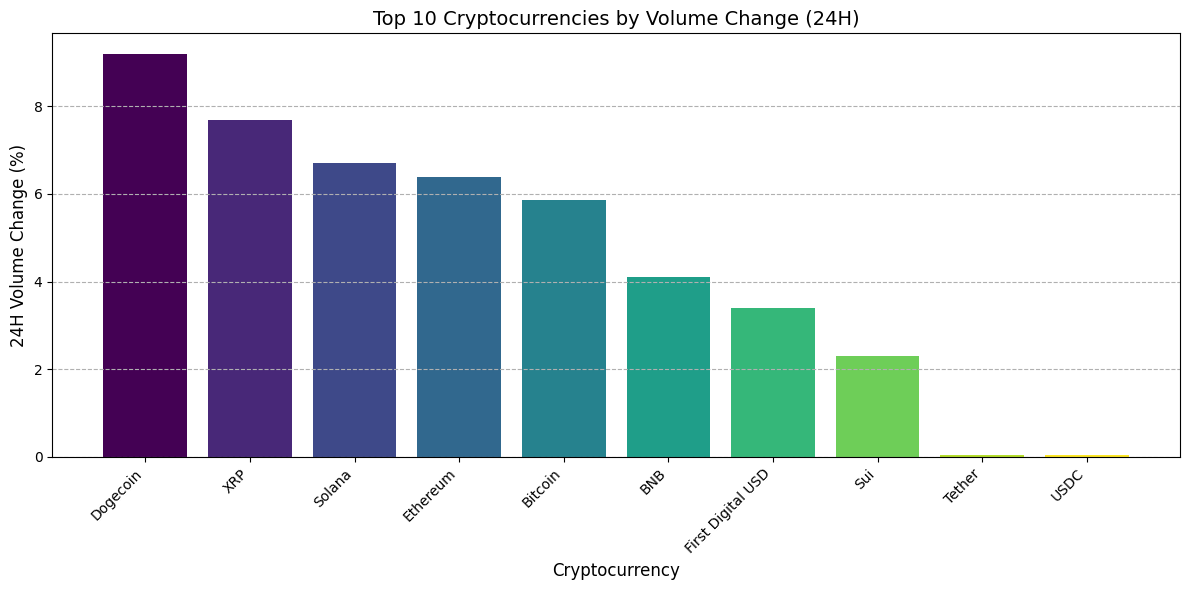

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data - replace with actual real-time data from a crypto API
data = {
    'Cryptocurrency': ['Tether', 'Bitcoin', 'Ethereum', 'USDC', 'XRP', 'Solana', 'First Digital USD', 'Dogecoin', 'BNB', 'Sui'],
    'Volume_Change': [0.05, 5.85, 6.39, 0.05, 7.68, 6.7, 3.4, 9.2, 4.1, 2.3]  # Example growth rates (%)
}

# 1. Create Pandas DataFrame
df = pd.DataFrame(data)

# Sort by Volume Change in descending order
df = df.sort_values(by='Volume_Change', ascending=False)

# 2. Generate Matplotlib bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(df['Cryptocurrency'], df['Volume_Change'], color=plt.cm.viridis(np.linspace(0, 1, len(df)))) # Color map for visual appeal
plt.xlabel('Cryptocurrency', fontsize=12)
plt.ylabel('24H Volume Change (%)', fontsize=12)
plt.title('Top 10 Cryptocurrencies by Volume Change (24H)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--')  # Add grid lines for easier comparison

# 3. Format the chart
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving Students_in_a_Harvard_Business_School_classroom.jpeg to Students_in_a_Harvard_Business_School_classroom.jpeg
Uploaded image:


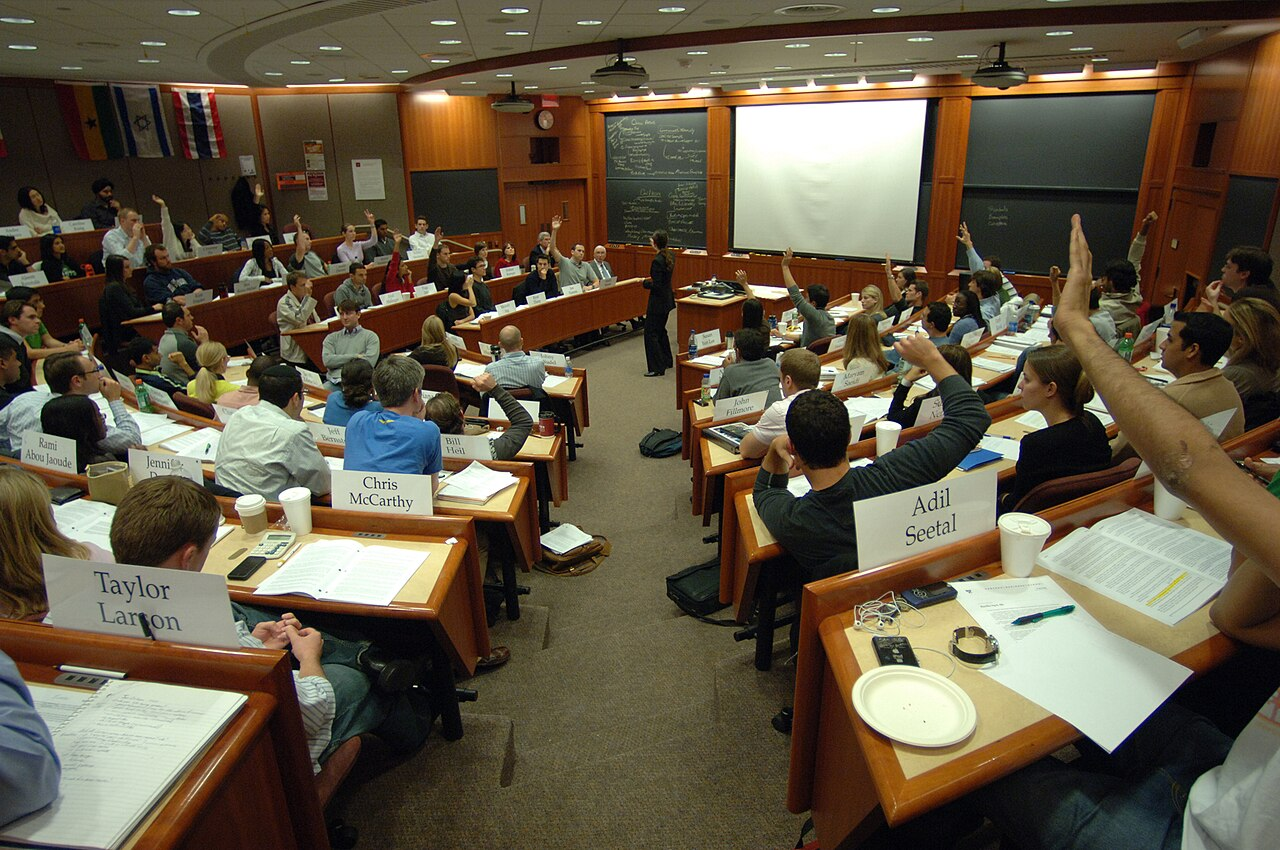


🔍 Analyzing image...


Here's the information extracted from the image, presented in the requested format:

**Main Subject:** Classroom Lecture

**Description:** A classroom or lecture hall filled with students, many of whom have their hands raised in participation. A person is standing at the front, likely a lecturer leading a discussion. Flags are displayed, and name cards are visible on the desks.



📊 Search Results Used:



🔍 Searching for detailed information...


Here's some more detailed information about lecture halls, compiled from the search results:

**History and Evolution:**

*   **Ancient Origins:** The concept of lectures dates back to ancient civilizations like Greece and India, where philosophers and enlightened thinkers shared their wisdom with learners.
*   **Medieval Period:** Lecture halls became central to education in monastic schools and early universities. Lecturers orally transmitted information, often using manuscripts as references.
*   **Renaissance:** The Renaissance, marked by the advent of printing, saw universities emerge as hubs of academic enlightenment.
*   **16th Century:** Lecture halls' earliest purpose was surrounding religious teaching. Pope Gregory VII allowed the clergy to copy religious manuscripts read by a 'lecturer'.
*   **Renaissance Italy:** Tiered lecture theaters were developed in Renaissance Italy, where they were used for teaching anatomy. The first purpose-built lecture theater of the modern era was in Padua in 1594.
*   **19th Century:** The "Harvard-style" lecture theatre developed, featuring a shallower rake and U-shaped seating to promote interaction. Upholstered seating and desks became common.
*   **21st Century:** "Collaborative lecture theatres" emerged with flexible seating for group work. "Mega lecture theatres" were also constructed, with diverse designs.

**Design and Functionality:**

*   **Tiered Seating:** Traditional lecture halls often have tiered seating, ensuring all attendees can see the speaker and presentation.
*   **Acoustics:** Good acoustics are essential for clear communication.
*   **Lighting:** Natural and artificial lighting are combined to create a conducive learning environment.
*   **Technology:** Modern lecture halls incorporate technology like projectors, interactive whiteboards, and smartboards. They also include audio-visual equipment, microphones, and speakers.
*   **Accessibility:** Modern lecture halls prioritize accessibility with ramps, elevators, and adaptable seating.
*   **Seating Arrangements**: Tiered seating is commonly used to provide views of the lecturer and encourage participation, in the class setting. Creative seating layouts, like customizable setups, are becoming more favored to cater to teaching approaches.

**Interesting Facts:**

*   Studies show that students tend to sit in specific locations in lecture halls based on factors like wanting to be noticed, anxiety, or ability to focus.
*   Peer groups impact attainment and engagement, with students of similar ability often sitting together.
*   The design of the lecture hall is based on that of the auditorium, designed for an audience and performer relationship, providing spectators with excellent visibility of the main stage or platform.

**Modern Trends:**

*   **Flexible Seating:** Modern lecture halls are moving towards flexible and modular seating designs to accommodate diverse learning styles and promote active engagement.
*   **Collaborative Spaces:** Collaborative furniture and flexible seating allow students to change the room easily, which helps with group talks, team projects, and hands-on learning.
*   **Hybrid Learning:** Advanced video conferencing systems enable hybrid learning models, providing remote access to lectures and seminars.



📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): What are they study?

🔍 Searching for answer to: 'What are they study?'


Without more specific clues from the image (like writing on the board or details on the papers in front of the students), it's impossible to know exactly what subject they are studying. However, I can offer some possibilities based on the context:

*   **Business/Law School:** The room's layout, with tiered seating and name cards, is common in business or law school settings. If this is the case, they might be studying business administration, law, or a related field.
*   **Humanities/Social Sciences:** Depending on the university and the professor's expertise, the lecture could be in a humanities subject like history, literature, or political science, or a social science like sociology or economics.
*   **Other Possibilities:** Depending on the university, this could also be a STEM (Science, Technology, Engineering, and Math) lecture hall.

The presence of name cards suggests that this is a course where active participation is encouraged.



📊 Search Results Used:


In [ ]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from google.genai.types import HttpOptions, Part
from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return image_file.read()

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    image_bytes = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""

    What is shown in this image? Please identify the main subject and provide a brief description in format below: \n
    Main Subject: subject \n
    Description: description \n
    """

    print("\n🔍 Analyzing image...")

    multimodal_chat.send_message([Part.from_bytes(data=image_bytes, mime_type="image/jpeg")])
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [ ]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Based on the latest available data, here is an analysis of the European electric vehicle (EV) market:

**Current State:**

*   **Overall Market Context:** The European light-vehicle market (passenger cars and light commercial vehicles) saw modest growth of 1.7% in 2024, following stronger growth in 2023. The market is still below pre-COVID-19 levels.
*   **EV Sales in 2024:** In 2024, the European EV market (including the EU, EFTA, and UK) experienced a slight downturn after years of growth. Over 2.96 million EVs (including Battery Electric Vehicles - BEVs and Plug-in Hybrid Electric Vehicles - PHEVs) were registered, a decrease of 1.8% compared to 2023. Some reports indicate a 3% decline for the EU, EFTA & UK region, totaling around 3.0 million units. Battery-electric vehicles (BEVs) accounted for the majority (67.7%) of these plug-in registrations in 2024.
*   **Recent Trends (Early 2025):** Early 2025 shows signs of recovery. In January 2025, EU BEV sales climbed 34% year-on-year, achieving a 15% market share. February 2025 saw continued year-over-year growth (estimated +20% vs Feb 2024), though slightly down from January. BEV market share held steady at 16% in February 2025. Combined BEV and PHEV market share reached 23% in Europe in February 2025.
*   **Powertrain Shift:** There's a clear shift towards electrification. In September 2024, BEVs and PHEVs combined held a 26% market share, and together with Hybrid Electric Vehicles (HEVs), electrified vehicles accounted for 60% of new car sales. Petrol and diesel sales are declining significantly. In January 2025, HEVs (34.9%) outsold petrol cars (29.4%) in the EU, with BEVs at 15% and diesel at 10%.

**Major Players & Market Share (Based on Full Year 2024 data unless stated):**

*   **Top Brands (EVs - BEV + PHEV):**
    1.  **Tesla:** Remained the top EV seller for the third year running with 328,036 deliveries (11.1% market share), despite a 10.4% decline from 2023. The Model Y and Model 3 were key drivers.
    2.  **BMW:** Secured second place with 292,407 registrations (9.9% market share), showing strong growth of 10.7%.
    3.  **Mercedes-Benz:** Moved up to third place with 258,677 registrations (8.7% market share), growing by 10%.
    4.  **Volvo:** Jumped to fourth with 239,255 deliveries (8.1% market share), marking a significant 42% surge.
    5.  **Volkswagen (VW):** Fell to fifth place with 229,836 deliveries (7.8% market share), experiencing a 6.7% decline.
    6.  **Audi:** Landed in sixth with 172,665 units (5.8% market share), a slight drop of 0.8%.
    7.  **Kia:** Remained seventh with 118,264 units (4.0% market share), despite a 13% volume decline.
    8.  **Peugeot:** Held eighth place with 115,771 registrations (3.9% market share).
    9.  **Skoda:** Moved up to ninth with 101,629 units (3.4% market share), a 4.1% increase.
    10. **Hyundai:** Rounded out the top 10 with 94,258 units (3.2% market share), experiencing a 14.6% decline.
*   **Group Performance (as of mid-2024):** Volkswagen Group maintained the lead in overall EV market share (around 20.8% in Sept 2024), followed by Tesla (around 11.4%), BMW Group (around 11.1%), and Stellantis (around 11.2% - 11.7%, facing challenges).
*   **Chinese Brands:** Chinese-owned brands (like Volvo, BYD, Polestar, MG) are increasing their presence. In February 2025, Chinese-owned brands collectively outsold Tesla in Europe for that month.

**Growth Trends:**

*   **Recent Slowdown (2024):** After strong growth in previous years (e.g., +20% in 2023 vs 2022), the European EV market stalled or slightly declined in 2024. Factors included the phasing out of subsidies in some key markets like Germany.
*   **Renewed Growth Expected (2025):** Analysts predict a significant rebound in 2025, driven by stricter EU CO2 emissions regulations coming into effect, forcing manufacturers to sell more EVs. Forecasts vary, but projections include:
    *   A 40% rise in Western European EV sales to 2.7 million units, with BEVs reaching a 22% market share.
    *   Overall European EV sales reaching 3.5 million units (around 10-15% growth).
    *   Some predict BEV sales alone could grow by as much as 67% to around 2.65 million units in Europe (EU, EFTA, UK).
    *   Key markets like Germany, the UK, and France are expected to lead this growth.
*   **Long-Term Outlook:** The long-term trend remains strongly towards electrification, supported by EU targets aiming for a 100% reduction in CO2 emissions for new cars and vans by 2035.
*   **Segment Growth:** Electrification is also growing in light commercial vehicles (LCVs), heavy-duty trucks, and buses, supported by specific regulations and targets.

In summary, while the European EV market experienced a temporary pause in growth during 2024, influenced by subsidy changes and market maturation, the underlying drivers and regulatory pressures point towards renewed and significant growth in 2025 and beyond. Established European automakers, Tesla, and increasingly, Chinese brands are the key players shaping this dynamic market.


📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow


In [ ]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "The value and application of crypto for retail investors?"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'The value and application of crypto for retail investors?'


Okay, here's a broad overview of the value and application of crypto for retail investors, covering the requested points:

**Overview: The Value and Application of Crypto for Retail Investors**

Cryptocurrencies have gained significant attention from retail investors (individual, non-professional investors) over the past decade. They present both potential opportunities and substantial risks, driven by technological innovation, market speculation, and evolving regulation.

**1. Main Concepts and Terminology**

Understanding these basic terms is crucial for navigating the crypto space:

*   **Cryptocurrency:** A digital or virtual currency secured by cryptography, making it difficult to counterfeit. Examples include Bitcoin (BTC) and Ethereum (ETH). They typically operate on decentralized networks. [20, 29]
*   **Blockchain:** A distributed, immutable ledger technology that records transactions across many computers. This ensures transparency and security and forms the foundation for most cryptocurrencies. [5, 12, 26]
*   **Wallet:** A digital tool used to store the public and private keys required to access and manage cryptocurrencies. Wallets can be "hot" (online, less secure) or "cold" (offline, more secure). [5, 29]
*   **Exchange:** Online platforms where users can buy, sell, and trade cryptocurrencies (e.g., Coinbase, Binance, Kraken). These are the primary gateways for retail investors. [4, 27]
*   **Decentralized Finance (DeFi):** Financial services built on blockchain technology that operate without traditional intermediaries like banks. Includes lending, borrowing, staking, and trading. [8, 16]
*   **Non-Fungible Token (NFT):** Unique digital assets representing ownership of items like art, collectibles, or even virtual land. Each token is distinct. [8, 5]
*   **Mining/Staking:** Processes used to validate transactions and secure the network. Mining (Proof-of-Work) involves solving complex puzzles, while Staking (Proof-of-Stake) involves locking up crypto holdings to support the network. Both can offer rewards to participants. [5, 12, 14]
*   **Fiat Currency:** Government-issued currency not backed by a physical commodity, like the US Dollar or Euro. Cryptocurrencies are generally not fiat currencies. [31]
*   **Stablecoins:** Cryptocurrencies designed to maintain a stable value, typically pegged 1:1 to a fiat currency like the US dollar (e.g., USDT, USDC). [2, 6]
*   **Altcoin:** Any cryptocurrency other than Bitcoin. [9]

**2. Current State of Development (Early 2025)**

*   **Increased Adoption & Accessibility:** Ownership has grown significantly, with platforms making it easier for retail investors to buy, sell, and store crypto. [18, 22] Bitcoin ETFs (Exchange Traded Funds) approved in the US in 2024 further increased accessibility for traditional investors. [3, 6, 10]
*   **Market Volatility:** Prices remain highly volatile, presenting both high return potential and significant risk of loss. [24, 33]
*   **Evolving Regulatory Landscape:** Regulation is a key theme. The EU implemented its MiCA framework for clarity, while the US regulatory stance has shifted towards being potentially more crypto-friendly under the current administration, although this is still developing. [1, 2, 10, 16, 19] Regulatory clarity (or lack thereof) significantly impacts retail confidence and market stability. [10, 21]
*   **Institutional Interest:** Growing institutional involvement (e.g., large asset managers offering crypto products) influences market dynamics and perceived legitimacy, indirectly affecting retail investors. [3, 10, 11]
*   **Focus on Utility:** While speculation remains dominant for many retail investors, there's ongoing development in DeFi, NFTs exploring practical uses, stablecoins, and integrating blockchain into traditional finance (tokenization of real-world assets). [3, 16, 18]

**3. Key Players or Contributors**

*   **Major Cryptocurrencies:**
    *   *Bitcoin (BTC):* The first and largest crypto, often seen as "digital gold" or a store of value. [18, 26, 31]
    *   *Ethereum (ETH):* The leading platform for smart contracts, DeFi, and NFTs. [25]
    *   *Stablecoins (USDT, USDC, etc.):* Crucial for trading and accessing DeFi, aiming for price stability. [6]
    *   *Altcoins:* Thousands of others (e.g., Solana, Cardano, Ripple's XRP) offering different technologies or use cases. [9, 13]
*   **Exchanges:** Central hubs for retail trading (Coinbase, Binance, Kraken, etc.). [4, 27, 28]
*   **Wallet Providers:** Companies offering secure storage solutions (Ledger, Trezor, MetaMask). [5]
*   **Blockchain Platforms:** Networks underpinning crypto applications (Ethereum, IBM Blockchain, Hyperledger Fabric, Ripple, R3 Corda, etc.). [4, 23, 25]
*   **Mining Companies:** Operations that secure Proof-of-Work networks like Bitcoin (e.g., Riot Platforms, Marathon Digital). [4]
*   **Regulators:** Government bodies setting the rules (e.g., SEC in the US, European authorities overseeing MiCA). [1, 2]
*   **Institutional Investors/Asset Managers:** Increasingly offering crypto products (e.g., BlackRock, Fidelity). [3, 10]

**4. Recent Major Developments (Late 2024 - Early 2025)**

*   **US Spot Bitcoin ETFs:** Approval in early 2024 significantly boosted accessibility and institutional involvement. Discussions around Ether ETFs continue. [3, 10, 22, 31]
*   **Regulatory Shifts (US):** The current administration has indicated a more favorable stance towards crypto, signing executive orders aimed at regulatory clarity and potentially relaxing enforcement. The SEC has recently closed investigations into some major players like Robinhood and Opensea and signaled dismissal of charges against Coinbase. [1, 2, 10, 21] However, some enforcement actions continue (e.g., OKX settlement). [1] Memecoins were declared not to be securities by the SEC. [1]
*   **Regulatory Clarity (EU):** Full implementation of the MiCA framework provides a comprehensive regulatory structure in the EU. [10, 16]
*   **Market Performance:** Bitcoin reached new all-time highs above $100,000 in late 2024 / early 2025. [6, 10, 11] The overall crypto market cap grew significantly in 2024. [11]
*   **Technological Advancements:** Continued development of Layer 2 scaling solutions for faster/cheaper transactions, exploration of AI-crypto synergies, and growth in Real-World Asset (RWA) tokenization. [3, 11]
*   **Stablecoin Developments:** Ongoing discussion and potential legislation around stablecoins in the US. [2, 15] Increased focus on wholesale Central Bank Digital Currencies (CBDCs) rather than retail ones. [6]
*   **Security Concerns:** Despite progress, hacks and exploits, particularly in DeFi, remain a significant issue, highlighting the need for robust security practices. [7, 16]

---

**Interesting Subtopics for Further Exploration:**

Based on the overview, here are 3-5 subtopics that offer depth and relevance for retail investors:

1.  **The Impact of Evolving Global Regulation on Retail Access and Security:** How do differing regulatory approaches (e.g., US's potentially friendlier but evolving stance vs. EU's structured MiCA vs. outright bans elsewhere) affect what retail investors can access, the safety of their investments, tax implications, and the types of platforms available to them? [1, 2, 10, 16] This directly impacts investor protection and market participation.
2.  **DeFi for Retail Investors: Navigating Opportunities and Risks Beyond Simple Trading:** Explore specific DeFi applications accessible to retail users (like staking, yield farming, decentralized lending/borrowing). What are the realistic potential returns, and what are the specific risks involved (e.g., smart contract vulnerabilities, impermanent loss, platform collapses, scams)? [16, 7] This delves into more advanced crypto applications.
3.  **Security Best Practices and Custody Choices for Individual Crypto Holders:** A deep dive into how retail investors can best protect their assets. Compare the pros and cons of holding crypto on exchanges versus using self-custody wallets (hardware vs. software). Analyze common threats (phishing, scams, malware) and effective mitigation strategies. [7, 16, 29] Asset security is paramount for investors. [28]
4.  **Assessing the 'Value' of Altcoins and NFTs: Beyond Hype and Speculation:** How can retail investors evaluate the long-term potential and utility of cryptocurrencies other than Bitcoin and Ethereum, or NFTs beyond digital art? This could involve analyzing tokenomics, project development, community strength, actual use cases, and distinguishing potential value from speculative bubbles, including the role of memecoins. [3, 18, 30]
5.  **The Role and Risks of Stablecoins in Retail Portfolios and DeFi:** Investigate how retail investors use stablecoins beyond just facilitating trades. Explore their use in earning yield (e.g., through lending protocols), cross-border payments, and as a perceived 'safe haven' within the volatile crypto market. Critically examine the different types of stablecoins and the risks associated with their pegs and reserves. [2, 6, 15]

These subtopics touch upon critical areas of risk, opportunity, security, and the fundamental value proposition of crypto assets specifically for the retail investor audience.


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are 3 subtopics selected from the previous list that are particularly valuable for further exploration regarding the value and application of crypto for retail investors:

---

**1. Subtopic: The Evolving Global Regulatory Landscape and its Impact on Retail Crypto Investors**

*   **Why it's Significant:** Regulation is arguably the single most important external factor shaping the crypto experience for retail investors. It directly dictates:
    *   **Legality and Access:** Whether and how investors can legally buy, sell, and hold crypto.
    *   **Investor Protection:** The safeguards in place against fraud, manipulation, and platform failures.
    *   **Market Stability:** Clear rules can reduce volatility and increase confidence, while uncertainty or crackdowns can trigger market instability.
    *   **Product Availability:** Regulations influence which types of crypto assets and services (like certain DeFi protocols or derivatives) are offered to retail clients in specific jurisdictions.
    *   **Taxation:** How crypto gains and transactions are treated for tax purposes.
*   **Specific Aspects for Deeper Research:**
    *   **Comparative Analysis:** A detailed comparison of the US regulatory approach (current administration's stance, SEC actions, potential legislation [1, 2, 10]) versus the EU's MiCA framework [10, 16]. Focus on differences in requirements for exchanges, stablecoin issuers, and investor disclosure.
    *   **Impact of ETFs:** Quantify the effect of US Spot Bitcoin ETFs on retail adoption, market liquidity, and investor perception of legitimacy. [3, 10, 31]
    *   **Taxation Clarity:** Investigate the current tax reporting requirements and ambiguities for retail crypto investors in major economies (e.g., treatment of staking rewards, DeFi earnings, NFT sales).
    *   **Enforcement Trends:** Analyze recent regulatory enforcement actions (like SEC cases or settlements [1, 21]) and their implications for retail-facing platforms and products.

---

**2. Subtopic: Decentralized Finance (DeFi) for Retail: Assessing Opportunities and Managing Novel Risks**

*   **Why it's Significant:** DeFi represents a major potential application of crypto beyond simply holding or trading assets, offering retail investors ways to potentially generate yield or access alternative financial services. However, it introduces complex, technology-specific risks unfamiliar to many. Understanding this balance is crucial for retail investors considering DeFi participation. It moves beyond basic investment into active participation in the crypto ecosystem. [8, 16]
*   **Specific Aspects for Deeper Research:**
    *   **Yield Generation Mechanisms:** Detailed breakdown of popular DeFi activities like staking, liquidity providing, and yield farming. Analyze the realistic potential returns versus the specific risks (e.g., impermanent loss, smart contract failure, slashing penalties). [16]
    *   **Security Vulnerabilities:** In-depth look at common DeFi security exploits (smart contract bugs, flash loan attacks, oracle manipulation, rug pulls) using recent case studies. [7, 16] How can retail users assess protocol security?
    *   **Platform Risk vs. Protocol Risk:** Differentiate between the risks inherent in a DeFi protocol's code/design versus the risks associated with the specific platforms or interfaces used to access it.
    *   **Usability and Accessibility:** Evaluate the user-friendliness and technical knowledge required for retail investors to safely participate in leading DeFi protocols.
    *   **Insurance and Recourse:** What options, if any, exist for retail users to recover funds lost in DeFi exploits or failures?

---

**3. Subtopic: Crypto Asset Security and Custody: Best Practices for Retail Investors**

*   **Why it's Significant:** The security of assets is fundamental. Unlike traditional finance where banks and brokers provide significant security layers and insurance (like FDIC), crypto investors often bear more direct responsibility for safeguarding their assets, especially with self-custody. Mistakes can lead to irreversible loss. Understanding custody options and security practices is non-negotiable for any retail investor. [5, 28, 29]
*   **Specific Aspects for Deeper Research:**
    *   **Custody Models Compared:** Detailed risk/benefit analysis of holding crypto on centralized exchanges versus using software "hot" wallets versus hardware "cold" wallets. [5, 28, 29] Include factors like convenience, control, and vulnerability to different types of threats.
    *   **Common Threats and Mitigation:** Catalog the most prevalent security threats targeting retail crypto investors (phishing, malware, SIM swapping, fake apps/websites, social engineering scams [7]) and provide actionable steps for prevention and detection.
    *   **Private Key Management:** Best practices for securely generating, storing, and backing up private keys and seed phrases – the core of self-custody security. [29]
    *   **Exchange Security Due Diligence:** How can retail investors assess the security measures and track record of centralized exchanges? [27, 28] What questions should they ask?
    *   **Incident Response:** What steps should a retail investor take immediately if they suspect their crypto assets or accounts have been compromised?

---


📊 Stage 3: Deep dive into first subtopic


Okay, let's conduct a comprehensive deep dive into the subtopic: **The Evolving Global Regulatory Landscape and its Impact on Retail Crypto Investors.**

---

**Deep Dive: The Evolving Global Regulatory Landscape and its Impact on Retail Crypto Investors**

The way governments and international bodies regulate cryptocurrencies is a critical factor influencing the experience, safety, and opportunities available to retail investors. This landscape is dynamic, fragmented, and constantly evolving, creating both challenges and potential benefits.

**1. Latest Research Findings or Developments (Early 2025)**

*   **US Shift Towards Regulatory Clarity (Potential):** Following the 2024 election, the US administration has signaled a potentially more crypto-friendly stance, evidenced by executive orders aimed at fostering responsible innovation and recent actions by the Securities and Exchange Commission (SEC). [1, 10] Notably, the SEC dropped investigations into platforms like Robinhood's crypto arm and Opensea, and signaled dismissal of charges against Coinbase. [1, 21] Furthermore, the SEC declared that memecoins are not securities. [1] This contrasts with earlier, more enforcement-heavy approaches. However, enforcement isn't gone; OKX settled significant charges with multiple US agencies in late 2024. [1]
*   **EU's MiCA Framework Implementation:** The European Union's Markets in Crypto-Assets (MiCA) regulation is now being implemented. This provides a comprehensive framework covering crypto-asset service providers (CASPs), issuers, stablecoins, and market abuse rules across the bloc. [10, 16] Its goal is to harmonize rules, protect investors, ensure financial stability, and foster innovation within a clear legal structure. [16]
*   **Spot Bitcoin ETFs Approval (US):** The SEC's approval of spot Bitcoin ETFs in early 2024 was a landmark regulatory decision. [3, 10, 31] While an investment product approval rather than direct crypto regulation, it provides retail investors with regulated, accessible exposure to Bitcoin via traditional brokerage accounts, significantly impacting accessibility and perceived legitimacy. [3, 31] Discussions around Ether ETFs continue. [22]
*   **Stablecoin Focus:** There's heightened regulatory focus globally on stablecoins due to their potential systemic importance and role in the crypto ecosystem. In the US, bipartisan legislative efforts continue, aiming to establish clear rules for issuers regarding reserves, operational standards, and redemption rights. [2, 15] MiCA also has specific, stringent requirements for stablecoin issuers in the EU. [16]
*   **International Coordination Efforts:** Organizations like the Financial Stability Board (FSB) and the G20 continue to push for global coordination and baseline standards to prevent regulatory arbitrage (where companies seek out jurisdictions with the laxest rules). [16]

**2. Key Challenges or Controversies**

*   **Global Fragmentation:** Despite coordination efforts, significant differences persist between jurisdictions (e.g., US state vs. federal complexities, differing US vs. EU approaches, outright bans in some nations). This creates compliance burdens for global crypto platforms and confusion for retail investors operating across borders. It can also lead to investor protection gaps. [10, 16]
*   **Defining Crypto Assets (Securities vs. Commodities):** A core controversy, particularly in the US, is whether specific crypto assets are securities (under SEC jurisdiction) or commodities (under CFTC jurisdiction). [2, 10, 21] This lack of clarity creates uncertainty for issuers and exchanges and impacts which investor protection rules apply. The recent SEC declaration on memecoins adds another dimension to this ongoing debate. [1]
*   **Regulating Decentralized Finance (DeFi):** Applying traditional financial regulations to decentralized protocols without intermediaries poses a significant challenge. Regulators grapple with identifying responsible parties and implementing effective oversight without stifling innovation. [16]
*   **Balancing Innovation and Investor Protection:** The perennial regulatory challenge: How to foster the potential benefits of crypto and blockchain (efficiency, financial inclusion) while mitigating substantial risks for retail investors (volatility, scams, fraud, platform collapses). [10, 16]
*   **Enforcement Difficulties:** The borderless and often pseudonymous nature of crypto makes enforcement against illicit activities (money laundering, terrorist financing, scams) difficult, requiring significant international cooperation and technological expertise.

**3. Notable Innovations or Breakthroughs (in Regulation/Policy)**

*   **MiCA Framework (EU):** Represents a breakthrough as the first major jurisdiction to implement a comprehensive, bespoke regulatory framework for crypto-assets, rather than trying to solely fit them into existing rules. Its structure serves as a potential model globally. [10, 16]
*   **US Spot Bitcoin ETFs:** The regulatory *approval* allowing these products is an innovation in *access*. It integrates crypto exposure into the traditional, highly regulated financial system, offering retail investors a familiar and potentially safer (from a custody/platform risk perspective) way to invest. [3, 10, 31]
*   **Targeted Stablecoin Legislation Efforts (US):** Moving towards dedicated legislation specifically for stablecoins, acknowledging their unique role and risks, is a notable development beyond applying general banking or securities laws. [2, 15]
*   **Increased Regulatory Dialogue:** While challenges remain, the level of discussion and focus from regulators, policymakers, and international bodies on crypto is unprecedented compared to a few years ago, signaling a move towards mainstream integration and oversight. [10, 16]

**4. Future Directions and Potential Impacts**

*   **Continued Push for US Clarity:** Expect ongoing debate and potential progress on US federal legislation (e.g., stablecoin bills, market structure bills) to provide clearer rules of the road, potentially reducing SEC vs. CFTC turf wars. [2, 10] Passage would likely boost retail confidence but could also impose stricter requirements on platforms.
*   **MiCA Implementation Effects:** As MiCA takes full effect, observe its impact on crypto businesses operating in the EU (some may leave, others will invest heavily in compliance) and whether it leads to a safer, more transparent market for European retail investors. Expect other jurisdictions to watch closely. [10, 16]
*   **Focus on DeFi and NFTs:** Regulators will likely turn more attention to developing frameworks for DeFi, potentially focusing on the user interface/platform providers or specific activities like lending/borrowing. NFT regulation regarding intellectual property, fractionalization, and market manipulation may also emerge. [16]
*   **Greater International Harmonization:** Anticipate increased efforts by bodies like the FSB and IOSCO to establish common global standards, particularly for stablecoins and crypto exchanges, to minimize regulatory arbitrage and systemic risk. [16]
*   **Impact on Retail Investors:**
    *   *Potential for Increased Safety:* Clearer rules and stronger oversight could lead to fewer platform collapses and scams.
    *   *Reduced Product Choice (Potentially):* Stricter regulations might lead some platforms to delist certain riskier assets or restrict access to complex products (like high-leverage derivatives) for retail users.
    *   *Easier Tax Compliance:* Clearer regulations often come with clearer tax guidance.
    *   *Integration with Traditional Finance:* Expect more regulated crypto products (like ETFs) becoming available through traditional brokers. [3, 10]

**5. Leading Experts, Organizations, or Companies**

*   **Regulatory Bodies:**
    *   US: Securities and Exchange Commission (SEC), Commodity Futures Trading Commission (CFTC), Treasury Department (including FinCEN and OFAC). [1, 2, 10, 21]
    *   EU: European Banking Authority (EBA), European Securities and Markets Authority (ESMA) - Key players in implementing MiCA. [10, 16]
    *   Others: UK's Financial Conduct Authority (FCA), Monetary Authority of Singapore (MAS), Japan's Financial Services Agency (FSA).
*   **International Organizations:** Financial Stability Board (FSB), G20, Bank for International Settlements (BIS), International Organization of Securities Commissions (IOSCO). [16]
*   **Industry/Advocacy Groups:** Blockchain Association, Chamber of Digital Commerce, Crypto Council for Innovation (Engage heavily in policy discussions).
*   **Think Tanks/Research:** Coin Center (focused on policy issues), various academic institutions with blockchain research programs.
*   **Major Companies (Influential via Compliance & Lobbying):** Large exchanges like Coinbase [27], Binance [28], Kraken; Stablecoin issuers like Circle (USDC) [6]; ETF providers like BlackRock, Fidelity. [3, 10] Their interpretation of and compliance with regulations significantly shape the retail environment.

---

In summary, the global regulatory landscape for crypto is a complex tapestry moving towards greater clarity, particularly in major markets like the EU and potentially the US. While this promises enhanced investor protection and market stability for retail participants, it also presents challenges related to global consistency, defining novel assets, and regulating decentralized systems. The approval of products like Bitcoin ETFs signals increasing integration with traditional finance, driven by regulatory acceptance. Future developments will likely focus on stablecoins, DeFi, and greater international coordination, profoundly impacting how retail investors access and interact with the crypto market.


📊 Stage 4: Synthesizing insights and recommendations


Okay, here is an executive brief synthesizing our research on the value, application, and regulatory environment of cryptocurrencies for retail investors.

---

**Executive Brief: Navigating the Crypto Landscape for Retail Investors**

**Date:** April 5, 2025

**Subject:** Strategic Insights into the Retail Crypto Market: Value, Application, and Regulation

**Overview:**
Cryptocurrencies present a dynamic and rapidly evolving asset class for retail investors, offering potential high returns alongside significant risks. Accessibility has increased dramatically, driven by user-friendly platforms and regulated products like US spot Bitcoin ETFs. However, the market remains characterized by volatility, evolving technology (like DeFi and NFTs), and a complex, fragmented global regulatory environment that is slowly moving towards greater clarity, particularly in major markets like the EU (via MiCA) and potentially the US. Understanding these intersecting forces is crucial for any entity engaging with the retail crypto market.

**1. Key Findings & Major Insights:**

*   **Accessibility Meets Volatility:** Crypto is easier than ever for retail investors to access, largely through exchanges and now regulated ETFs [3, 10, 18]. However, this ease of access is paired with inherent high price volatility and novel risks (technological, platform-related, regulatory) that are distinct from traditional assets [24, 33]. Retail investors often lack the resources for extensive due diligence.
*   **Regulation is the Dominant External Force:** Government regulation (or lack thereof) profoundly shapes retail crypto participation. Key developments like the EU's MiCA framework [10, 16] and potential shifts towards clearer rules in the US [1, 2, 10, 21] directly impact investor protection, product availability, platform requirements, market stability, and overall confidence. Fragmentation remains a key challenge [10, 16].
*   **Beyond Bitcoin: Expanding Use Cases & Associated Risks:** While Bitcoin remains dominant [18, 26, 31], retail interest extends to Ethereum, altcoins, stablecoins, NFTs, and DeFi applications [8, 9, 16]. These offer diverse potential (yield generation, unique digital ownership) but also introduce complex risks like smart contract vulnerabilities, impermanent loss, and specific stablecoin de-pegging risks [2, 7, 16]. Assessing the *utility* versus speculative hype is critical [18, 30].
*   **Security & Custody are Paramount but Underappreciated:** Protecting crypto assets is vital, yet retail investors often face challenges understanding the trade-offs between holding assets on exchanges (convenience, counterparty risk [27, 28]) versus self-custody (control, personal security responsibility [5, 29]). Security breaches, scams, and user error leading to irreversible loss remain significant threats [7].

**2. Emerging Trends & Patterns:**

*   **Mainstreaming via Regulated Products:** The approval of US Bitcoin ETFs marks a trend towards integrating crypto exposure into traditional finance channels, potentially broadening the retail base and attracting more cautious investors [3, 10, 31]. A similar trend may follow for other major assets like Ether [22].
*   **Regulatory Convergence (Slowly):** Despite fragmentation, there's a discernible trend towards establishing baseline global standards (driven by FSB, G20 [16]) and comprehensive national frameworks (like MiCA [10, 16]), moving away from initial uncertainty or outright bans towards structured oversight.
*   **Focus on Stablecoins and Infrastructure:** Regulators globally are prioritizing stablecoin oversight due to financial stability concerns [2, 15, 16]. Simultaneously, development continues on core infrastructure like Layer 2 scaling solutions to improve blockchain efficiency [11].
*   **Persistent Tension: Innovation vs. Control:** The core tension between the decentralized, permissionless ethos of crypto's origins and the need for centralized control points for effective regulation and investor protection continues to shape developments in areas like DeFi [16].

**3. Gaps & Contradictions in Current Knowledge:**

*   **Asset Classification Uncertainty:** The fundamental debate (especially in the US) over whether specific crypto assets are securities, commodities, or something else remains largely unresolved, creating persistent regulatory ambiguity [1, 10, 21].
*   **Measuring Real DeFi Risk Exposure:** Quantifying the actual risk exposure and potential losses for retail participants in DeFi due to complex factors like smart contract bugs or economic exploits is difficult and often relies on post-mortem analyses [7, 16].
*   **Long-Term Impact of Regulatory Divergence:** The practical, long-term consequences for markets and investors of differing regulatory approaches (e.g., EU vs. US vs. Asia) are still unfolding.
*   **Reliable Valuation Methods for Altcoins/NFTs:** Beyond speculation, generally accepted frameworks for valuing the utility or fundamental worth of many altcoins and NFTs are lacking [18, 30].

**4. Recommendations for Practical Applications:**

*   **For Retail Investors:** Prioritize education on security best practices (especially custody and scam avoidance [5, 7, 29]). Understand the specific risks of different crypto assets/activities (volatility, DeFi protocols [16, 24]). Diversify cautiously and only invest what can be afforded to lose. Stay informed about regulatory developments in your jurisdiction.
*   **For Platforms/Exchanges:** Invest heavily in robust security measures and clear communication about risks [27, 28]. Proactively engage with regulators to shape clear frameworks. Simplify user interfaces, especially for complex activities like DeFi access or staking, while ensuring adequate risk warnings. Prepare for varying compliance demands across jurisdictions (e.g., MiCA readiness [16]).
*   **For Regulators/Policymakers:** Strive for greater jurisdictional clarity and international coordination to minimize arbitrage [16]. Focus on technology-neutral regulations where possible, addressing illicit activity risks while allowing responsible innovation. Enhance investor education initiatives regarding crypto-specific risks. Continue developing frameworks for stablecoins and DeFi oversight [2, 15, 16].

**5. Suggested Directions for Future Research:**

*   **Comparative Regulatory Effectiveness:** Conduct longitudinal studies comparing investor protection outcomes, market stability, and innovation levels in jurisdictions with different regulatory models (e.g., post-MiCA EU vs. evolving US approach).
*   **Retail Behavior in DeFi:** Investigate how retail investors actually perceive, manage, and react to the unique risks within DeFi protocols. What factors influence their participation and risk-taking?
*   **Impact of Institutionalization on Retail:** Analyze how increased institutional involvement and products like ETFs affect market structure, volatility, correlations with traditional assets, and the overall experience for retail investors. [3, 10]
*   **Standardized Risk Assessment for Crypto Assets:** Develop and test frameworks for assessing the multifaceted risks (technological, market, regulatory, security) of different types of crypto assets beyond simple price volatility, aimed at informing retail decision-making.
*   **Effectiveness of Security Education:** Research the most effective methods for educating retail investors about crypto security threats and best practices to demonstrably reduce asset loss.

---


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [ ]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Okay, I will conduct a comprehensive analysis of Rivian in the Electric Vehicle (EV) manufacturing industry, covering the points you specified.



Here's a comprehensive analysis of Rivian in the EV manufacturing industry, based on the information gathered:

**1. Company Overview**

*   **History:** Rivian Automotive, Inc. was founded in 2009 by Robert "RJ" Scaringe, initially as Mainstream Motors. It was later renamed Avera Automotive before becoming Rivian Automotive in 2011. The company originally focused on developing a sports car but shifted its focus to electric and autonomous vehicles.
*   **Size:** Rivian has approximately 14,861 employees (as of December 2023).
*   **Key Offerings:** Rivian designs, develops, and manufactures electric vehicles and accessories. Its primary products include:
    *   **R1T:** A two-row, five-passenger electric pickup truck.
    *   **R1S:** A three-row, seven-passenger electric SUV.
    *   **Electric Delivery Van (EDV):** Designed and engineered in collaboration with Amazon for commercial deliveries. Rivian also offers FleetOS, a fleet management subscription platform and various services including vehicle repair, maintenance, financing, and insurance.
*   **Facilities:** Rivian is headquartered in Irvine, California. Its manufacturing plant is located in Normal, Illinois. The company also has facilities in Palo Alto and Carson, California; Plymouth, Michigan; Burnaby, British Columbia; Wittmann, Arizona; Woking, England; and Belgrade, Serbia. Plans to build a $5 billion factory in Georgia were put on hold but have restarted with a $6 billion loan from the US Department of Energy.

**2. Current Market Position and Market Share**

*   Rivian is considered an emerging player in the EV market, differentiating itself with a focus on "adventure vehicles" – electric trucks and SUVs designed for off-road capabilities.
*   Rivian's market share in the U.S. EV market was approximately 0.41% as of 2024.
*   While Tesla dominates the EV market, Rivian is positioned as a strong contender to fill the gap for consumers seeking alternatives, particularly with the upcoming R2 model.
*   Rivian's strategy involves targeting the electric truck and SUV segment, distinguishing it from other EV companies with more conventional approaches.

**3. Recent Financial Performance and Growth Trends**

*   **Revenue:** For the full year 2024, Rivian reported net revenue of $4.434 billion.
*   **Net Loss:** Rivian recorded a net loss of $1.2 billion for the full year 2024, an improvement from the $2.03 billion loss in 2023.
*   **Gross Profit:** Rivian achieved a gross profit of $170 million in Q4 2024.
*   **Production & Deliveries:** In 2024, Rivian produced 49,476 vehicles and delivered 51,579 vehicles. In Q4 2024, 12,727 vehicles were produced and 14,183 were delivered.
*   **Q1 2025 Production and Deliveries:** Rivian produced 14,611 vehicles and delivered 8,640.
*   **Liquidity:** Rivian ended Q1 2024 with $7.858 billion in cash, cash equivalents, and short-term investments.
*   **Cost Reduction:** Rivian reduced automotive cost of goods sold by $31,000 per vehicle in Q4 2024 compared to Q4 2023.
*   **Outlook:** Rivian anticipates a modest gross profit for 2025.

**4. Key Executives and Leadership Changes**

*   **Key People**
    *   **RJ Scaringe:** Founder and Chief Executive Officer
    *   **Claire McDonough:** Chief Financial Officer
    *   **Javier Varela:** Chief Operating Officer
    *   **Jeffrey R Baker:** Chief Accounting Officer
    *   **Sarah O'Brien:** Chief Communications Officer
    *   **Dagan Mishoulam:** Senior Vice President, Commercial
*   **Recent Changes:**
    *   **Javier Varela** became Chief Operating Officer in May 2024.
    *   **Dagan Mishoulam** assumed the role of Senior Vice President, Commercial, in July 2024, following the resignation of Kjell Gruner (Chief Commercial Officer and President, Business Growth). Kjell Gruner resigned effective July 26, 2024, but remained with the company until February 17, 2025, to assist with the transition.

**5. Recent Strategic Moves**

*   **Partnership with Volkswagen Group:** Volkswagen Group plans to invest up to $5 billion in Rivian, including $1 billion initially and an additional $4 billion through 2026. The companies have formed a joint venture to develop next-generation electrical architecture and software technology. The total deal size is up to $5.8 billion.
*   **Department of Energy Loan:** Rivian secured a loan agreement with the U.S. Department of Energy for up to $6.6 billion for its Georgia manufacturing facility.
*   **NACS Adoption:** Rivian will incorporate Tesla's North American Charging System (NACS) into its vehicles in 2025.
*   **Acquisition of Iternio:** Rivian acquired Iternio, the Swedish mapping company known for the "A Better Route Planner" (ABRP) EV route-planning app, integrating it into its in-car navigation system.
*    **Commercial Van Expansion:** Rivian opened sales of its Electric Delivery Van (EDV) to fleets of all sizes across the US.
*   **New Models:**
    *   **R2 SUV:** A smaller, less-expensive SUV on a new platform, scheduled to launch in early 2026, starting at $45,000.
    *   **R3/R3X:** Rivian is also planning future R3 and R3X models.
*   **Other Partnerships:**
    *   Rivian has partnered with Progressive, in addition to Nationwide and Cincinnati Insurance for Rivian Insurance.
    *   Rivian expanded its collaboration with XPEL to launch a new customization program for R1T and R1S electric vehicle owners in the US and Canada.

I have attempted to provide the most up-to-date and accurate information available as of today, April 5, 2025.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Okay, I will identify the top 3-5 direct competitors of Rivian, providing a comparative analysis based on the points you specified.



Here's a structured comparative analysis of Rivian's top competitors:

**Competitors:**

1.  **Tesla**
2.  **Ford**
3.  **General Motors**
4.  **Lucid Group**

| Feature                      | Rivian                                                                                                                                                                                                                                  | Tesla                                                                                                                                                                                                                                                                                                                                                        | Ford                                                                                                                                                                                                                                                               | General Motors                                                                                                                                                                                                                                                                     | Lucid Group                                                                                                                                                                                                                                                                                                                              |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Company Overview**      | Focuses on "adventure vehicles" - electric pickup trucks and SUVs (R1T and R1S), and Electric Delivery Vans (EDV).                                                                                                                           | Dominates the EV market with a range of sedans, SUVs, and the Cybertruck.                                                                                                                                                                                                      | A traditional automaker making a transition to EVs; offers the F-150 Lightning, Mustang Mach-E, and E-Transit.                                                                                                                                                             | Another traditional automaker investing heavily in EVs; offers the Chevrolet Silverado EV, Blazer EV, Equinox EV, and Cadillac Lyriq.                                                                                                                                             | Focuses on luxury EVs, primarily the Air sedan and the upcoming Gravity SUV.                                                                                                                                                                                                                                                                           |
| **2. Market Share & Position** | Niche player with approximately 0.41% U.S. EV market share (2024). Positioned as a premium alternative, particularly in the electric truck and SUV segment.                                                                                 | Market leader with approximately 44% of the U.S. EV market share (Q4 2024).                                                                                                                                                                                                | Held approximately 7% of the U.S. EV market share as of February 2025.                                                                                                                                                                                             | Held approximately 5.5% of the U.S. EV market share as of February 2025; was the second-largest seller of EVs in the U.S. during the second half of 2024.                                                                                                                 | Niche player focused on the luxury segment; sold 5,766 Air models in the U.S. through September 2024, surpassing Audi e-tron and Porsche Taycan.                                                                                                                                                                                                |
| **3. Key Differentiators & Advantages** | Strong brand image associated with adventure and sustainability; Innovative features and design catering to outdoor enthusiasts.                                                                                                          | Established brand recognition; extensive Supercharger network; advanced technology and self-driving capabilities.                                                                                                                                                              | Brand recognition; established manufacturing and service infrastructure; versatile F-150 Lightning appealing to both commercial and consumer markets.                                                                                                                      | Brand recognition; diverse product portfolio across various segments; increasing EV sales and market share.                                                                                                                                                                      | Focus on luxury and performance; proprietary technology including a 900V+ architecture for fast charging; stylish design.                                                                                                                                                                                                                         |
| **4. Recent Strategic Moves**   | Partnership with Volkswagen Group; Secured a loan from the U.S. Department of Energy; NACS adoption; Expansion of EDV sales to fleets of all sizes across the US.                                                                      | Expanding production capacity globally; focusing on cost reduction; launching new models, including the Cybertruck.                                                                                                                                                              | Increasing EV production; investing in battery technology and charging infrastructure; launching new EV models; expanding the BlueOval Charging Network.                                                                                                                      | Launching new EV models (e.g., Equinox EV, Blazer EV); increasing EV production; aiming to reduce EV operating losses.                                                                                                                                                      | Starting orders for the Gravity SUV; cost-cutting efforts; focusing on increasing production volume and deliveries; expanding into new markets.                                                                                                                                                                                                    |
| **5. Strengths**               | Unique positioning in the adventure vehicle segment; high customer satisfaction ratings; strong partnerships.                                                                                                                               | Market leadership; superior technology; brand loyalty; extensive charging infrastructure.                                                                                                                                                                                 | Established brand; strong truck sales; versatile product lineup; growing EV sales.                                                                                                                                                                                               | Strong brand; diverse product portfolio; growing EV sales and market share.                                                                                                                                                                                                    | High-performance vehicles; luxurious design and features; advanced technology.                                                                                                                                                                                                                                                               |
| **6. Weaknesses**              | Limited production capacity; high cash burn rate; relatively small market share; profitability challenges.                                                                                                                             | Declining market share; reliance on a single brand; potential supply chain disruptions.                                                                                                                                                                                 | Transitioning from traditional vehicles; dependence on third-party battery suppliers; lower EV market share compared to Tesla and GM.                                                                                                                                        | Slower EV ramp-up compared to Tesla; reliance on traditional ICE vehicle sales; profitability challenges in the EV segment.                                                                                                                                                    | Low production volume; high cash burn rate; significant losses; limited brand recognition compared to legacy automakers.                                                                                                                                                                                                                      |

**Key Takeaways:**

*   **Tesla** remains the dominant player in the EV market, but its market share is being challenged by both traditional automakers like Ford and GM, and newer entrants.
*   **Rivian** has carved out a niche in the "adventure vehicle" segment, differentiating itself with its focus on electric trucks and SUVs designed for off-road capabilities. However, it faces challenges in scaling production and achieving profitability.
*   **Ford** and **General Motors** are leveraging their established brands, manufacturing capabilities, and dealer networks to compete in the EV market. Both companies are investing heavily in EVs and launching new models.
*   **Lucid** is targeting the luxury EV segment with its high-performance, stylish vehicles. However, it faces challenges in increasing production volume and competing with established luxury brands.

This comparative analysis should provide a comprehensive understanding of Rivian's competitive landscape within the EV manufacturing industry.



📊 Search Results Used:



📊 Stage 3: SWOT analysis for Rivian


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}

# Workshop Summary

In [ ]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
